In [151]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

from bs4 import BeautifulSoup
from pandas import DataFrame
import pandas as pd
import string

def numberfix(x):
    if x=='':
        return 0
    elif x=='*':
        return 1
    else:
        try:
            return int(''.join([c for c in x if c != ',']))
        except:
            return x

def htmlToDataFrame(filename):
    bs=BeautifulSoup(open(filename))
    t=bs.div.find_all("div")
    colnamemap={header["class"][-1]:string.strip(header.getText()) for header in bs.find_all("div",class_="ngHeaderText")}
    rowcontents=[{cell["class"][3]:string.strip(cell.getText()) 
              for cell in row.find_all("div", class_="ngCellText")} 
              for row in bs.find_all("div",class_="ngRow")]

    t=DataFrame(rowcontents)[['colt'+str(i) for i in range(14)]].rename(columns=colnamemap)
    t.columns=['year','destination','origin','typeLevel','totalYearStart','totalYearStartUnhcr',
          'appliedDuringYear','recognized','other','rejected','otherClosed','totalDecisions','totalYearEnd','totalYearEndUnhcr']
    for column in t.columns[4:]:
        t[column]=t[column].apply(numberfix)
    t.year=t.year.apply(int)
    return t

aus=pd.concat([htmlToDataFrame("australia2015_"+str(x)+".html") for x in range(1,6)])
mly=pd.concat([htmlToDataFrame("malaysia2015_"+str(x)+".html") for x in range(1,3)])

fullhist = pd.read_csv('unhcr_popstats_export_asylum_seekers_all_data.csv').fillna(0)
fullhist.columns=aus.columns
for column in fullhist.columns[4:]:
    fullhist[column]=fullhist[column].apply(numberfix)
fullhist.year=fullhist.year.apply(int)    
    
indo = pd.read_csv('unhcr_popstats_export_asylum_seekers_2017_03_04_184046.csv').fillna(0)
indo.columns=aus.columns
for column in indo.columns[4:]:
    indo[column]=indo[column].apply(numberfix)
indo.year=indo.year.apply(int)    

AsylumHistory = pd.concat([aus,mly,indo,fullhist])


In [211]:
def typeLevels(t):
    return t[~(t.typeLevel.str.endswith('/ AR'))].typeLevel.drop_duplicates().sort_values().reset_index(drop=True)

AsylumHistory[AsylumHistory.destination.isin(['Indonesia','Malaysia','Australia'])].groupby(['year','destination']).apply(typeLevels)

AsylumHistory[(AsylumHistory.typeLevel.str.endswith('/ AR'))]


AsylumHistory[AsylumHistory.origin=='Afghanistan'].groupby('typeLevel')['appliedDuringYear'].sum().sort_values()[-5:].index

Index([u'U / FA', u'G / NA', u'G / FA', u'U / FI', u'G / FI'], dtype='object', name=u'typeLevel')

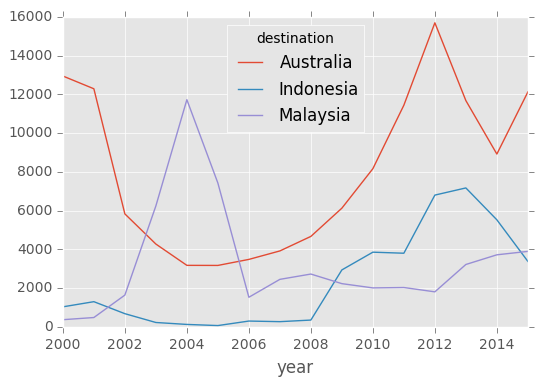

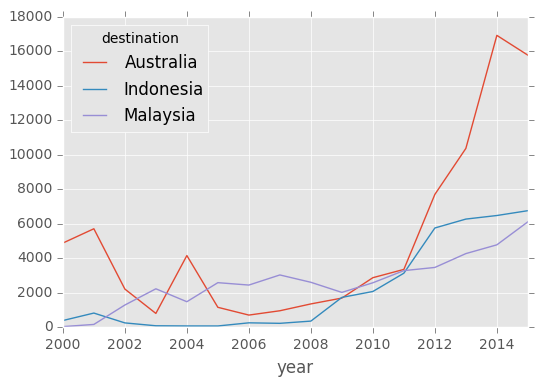

In [225]:
t = AsylumHistory[AsylumHistory.destination.isin(['Australia','Malaysia','Indonesia'])]
t=t[t.origin!='Myanmar']
t = t[t.typeLevel.isin([u'U / FA', u'G / NA', u'G / FA', u'U / FI', u'G / FI'])]


t.groupby(['year','destination']).appliedDuringYear.sum().unstack().plot.line()

t.groupby(['year','destination']).totalYearEnd.sum().unstack().plot.line()

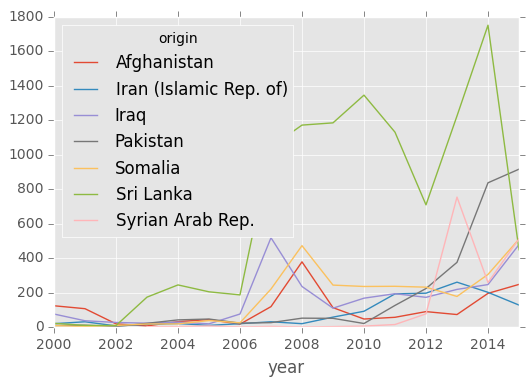

In [254]:
t = AsylumHistory[(AsylumHistory.destination.isin(['Malaysia']))&(~(AsylumHistory.origin.isin(['Myanmar'])))]

t=t[t.origin.isin(t.groupby('origin')['appliedDuringYear'].sum().sort_values()[-8:-1].index)]
t.groupby(['year','origin']).appliedDuringYear.sum().unstack().plot.line()


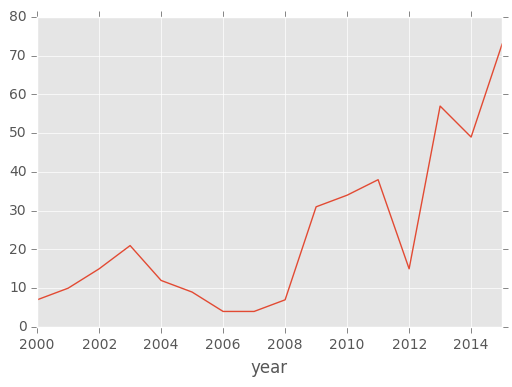

In [284]:
t=AsylumHistory[(AsylumHistory.destination.isin(['Indonesia']))&((AsylumHistory.origin
                                    .isin(['Togo','Ghana','Senegal','Rwanda','Sierra Leone',
                                           'Uganda','Central African Rep.','Benin','Côte d\'Ivoire','Cameroon','Dem. Rep. of the Congo','Congo','Eritrea',
                                          'Guinea','Gambia','Mali','Nigeria'])))]


t.groupby(['year'])['appliedDuringYear'].sum().plot.line()